# Figure 10: WGI (v4) Reference Regions — **Land** and **Land + Land‑Ocean**  
*(Iturbide et al., 2020)*

This notebook plots the **IPCC AR6 WGI v4 reference regions** from the CSV by Iturbide et al. (2020).  

We generate **two figures** by default:
1. **Land** regions only.  
2. **Land + Land‑Ocean** (i.e., land regions plus the three *hybrid* regions: CAR, MED, SEA).  

You can turn either figure on/off in the *Configuration* cell below.


## 1) Configuration

Set the CSV path (auto-detected if the file is in the working directory) and choose which figures to make.


In [1]:
# %%
from pathlib import Path

# (A) Path to the CSV with vertices
# The notebook will try to auto-detect a file named like 'IPCC-WGI-reference-regions-v4_coordinates*.csv'.
# If your file lives elsewhere, hardcode it in CSV_PATH below.
_candidates = sorted(Path('.').glob('IPCC-WGI-reference-regions-v4_coordinates*.csv'))
CSV_PATH = _candidates[0] if _candidates else Path('Building_Interpretable_Climate_Emulators_forEconomics/figures_replication/figure_10/IPCC-WGI-reference-regions-v4_coordinates.csv')

# (B) Which maps to produce
PLOT_LAND = True                      # Fig. 1: Land-only
PLOT_LAND_PLUS_LANDOCEAN = True       # Fig. 2: Land + Land-Ocean (hybrid regions included; ocean-only excluded)

# (C) Output directory and filenames
OUTDIR = Path('fig'); OUTDIR.mkdir(exist_ok=True)
FN_LAND = OUTDIR / 'wgi_v4_land'
FN_LAND_PLUS_LANDOCEAN = OUTDIR / 'wgi_v4_land_plus_landocean'

# (D) File formats to save (comment out any you don't want)
SAVE_FORMATS = ('png', 'pdf', 'svg')


## 2) Dependencies

If any of the following packages are missing in your environment, uncomment the `%pip` line and run it.
`Cartopy` may take a few minutes on the first install.


In [2]:
# %%
# %pip install -q pandas matplotlib cartopy shapely pyproj


In [3]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Cartopy for maps and graticules
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Shapely for polygon construction and geometry ops
from shapely.geometry import Polygon, MultiPolygon

# A few Matplotlib defaults for publication-style figures
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
})


## 3) Load the coordinate table

The CSV contains one row per region with a fixed set of metadata columns and then a *variable-length list* of
vertex columns (e.g. `Vertex1`, `Vertex2`, … plus some unnamed columns). Each vertex is encoded as `"lon|lat"`.


In [4]:
# %%
df = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH}")
print("Rows:", len(df))
print("Columns:", list(df.columns))
display(df.head(3))


Loaded: Building_Interpretable_Climate_Emulators_forEconomics/figures_replication/figure_10/IPCC-WGI-reference-regions-v4_coordinates.csv
Rows: 62
Columns: ['Continent / Ocean', 'Surface', 'Reference region name', 'Acronym', 'Vertex1', 'Vertex2', 'Vertex3', '...', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17']


,Continent / Ocean,Surface,Reference region name,Acronym,Vertex1,Vertex2,Vertex3,...,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,POLAR,Land,Greenland/Iceland,GIC,-10.0|62.0,-38.0|62.0,-42.0|58.0,-50.0|58.0,-82.0|85.0,-10.0|85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NORTH-AMERICA,Land,N.W.North-America,NWN,-105.0|50.0,-130.0|50.0,-143.0|58.0,-168.0|52.5,-168.0|72.6,-129.0|72.6,-125.0|77.6,-105.0|81.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NORTH-AMERICA,Land,N.E.North-America,NEN,-50.0|50.0,-50.0|58.0,-82.0|85.0,-105.0|81.0,-105.0|50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Utility functions

- **`_parse_vertices_from_row`** — reads the variable-length vertex list and returns a list of (lon, lat) tuples.  
- **`row_to_polygon`** — builds a Shapely `Polygon` (repairs invalid rings via `.buffer(0)` if needed).  
- **`build_region_geoms`** — filters rows by `Surface` (e.g., `Land`, `Land-Ocean`, `Ocean`) and returns a list of
  dictionaries with geometry and metadata.  
- **`plot_regions`** — draws the map in the requested style:
  - light-grey land background
  - coastlines + borders
  - **red** polygon outlines (region boundaries)
  - **blue** acronym text placed at a representative point of each polygon part
  - dotted graticule with labeled parallels/meridians


In [5]:
# %%
from typing import List, Tuple

def _parse_vertices_from_row(row: pd.Series) -> List[Tuple[float, float]]:
    """Extract vertices (lon, lat) from a single CSV row.
    
    The CSV stores vertices starting at column index 4 (0-based), under headers like
    'Vertex1', 'Vertex2', ... and possibly 'Unnamed: N' for additional vertices.
    Each cell contains a string 'lon|lat'. We parse all non-empty entries.
    """
    pts: List[Tuple[float, float]] = []
    for col in row.index[4:]:  # skip metadata columns: [Continent/Ocean, Surface, Name, Acronym]
        val = row[col]
        if isinstance(val, str) and '|' in val:
            try:
                lon_str, lat_str = val.split('|')
                lon, lat = float(lon_str), float(lat_str)
                pts.append((lon, lat))
            except Exception:
                # If a malformed vertex is encountered, we skip it.
                # (Not expected here, but safe against stray characters/encoding issues.)
                pass
    return pts

def row_to_polygon(row: pd.Series) -> Polygon:
    """Construct a Shapely Polygon from a row's vertex list.
    
    Notes
    -----
    - The vertices are assumed to be ordered to form the outer boundary of the region.
    - If the polygon is 'invalid' (e.g., slight self-intersection due to repeated points),
      we apply the standard repair trick `buffer(0)` which returns a cleaned geometry.
    - Regions that span the antimeridian are not present in this v4 table; if they were,
      one would typically pre-process longitudes to ensure proper wrapping.
    """
    pts = _parse_vertices_from_row(row)
    poly = Polygon(pts)
    if not poly.is_valid:
        poly = poly.buffer(0)  # clean simple self-intersections
    return poly

def build_region_geoms(df: pd.DataFrame, surfaces: List[str]):
    """Collect region geometries for any row whose 'Surface' is in `surfaces`.
    
    Parameters
    ----------
    df : DataFrame
        The full CSV as a DataFrame.
    surfaces : list of str
        E.g. ['Land'], or ['Land', 'Land-Ocean'].
    
    Returns
    -------
    List[dict]
        Each dict contains:
          - 'acronym'  (e.g. 'MED')
          - 'name'     (full region name)
          - 'surface'  ('Land', 'Land-Ocean', or 'Ocean')
          - 'geom'     (Shapely Polygon/MultiPolygon)
          - 'continent_ocean' (the WGI grouping column)
    """
    out = []
    mask = df['Surface'].isin(surfaces)
    for _, row in df[mask].iterrows():
        poly = row_to_polygon(row)
        out.append({
            'acronym': row['Acronym'],
            'name': row['Reference region name'],
            'surface': row['Surface'],
            'geom': poly,
            'continent_ocean': row['Continent / Ocean'],
        })
    return out

def plot_regions(ax, regions, title: str):
    """Render region boundaries and labels onto a Plate Carrée world map.
    
    Styling choices mirror the example figure:
    - Land in **light grey**
    - **Red** region outlines
    - **Blue** acronym labels (one label per polygon *piece*)
    - Gridlines with labels (dotted)
    """
    proj = ccrs.PlateCarree()
    ax.set_global()
    
    # Base map
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', zorder=0)
    ax.coastlines(resolution='110m', linewidth=0.6, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, zorder=2)

    # Draw each region's exterior outline in red.
    # If a region is a MultiPolygon (e.g., islands), plot each piece.
    for r in regions:
        g = r['geom']
        geoms = list(g.geoms) if isinstance(g, MultiPolygon) else [g]
        for geom in geoms:
            xs, ys = geom.exterior.xy
            ax.plot(xs, ys, transform=proj, color='red', linewidth=1.0, zorder=3)

    # Place acronym labels at representative points (a point guaranteed to lie within the polygon).
    for r in regions:
        g = r['geom']
        ac = r['acronym']
        geoms = list(g.geoms) if isinstance(g, MultiPolygon) else [g]
        for geom in geoms:
            rp = geom.representative_point()
            ax.text(rp.x, rp.y, ac, transform=proj, ha='center', va='center',
                    fontsize=8, color='blue', zorder=4)

    # Graticule (lon/lat grid)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, linestyle=':', zorder=1)
    # Label behavior differs across cartopy versions; try to enable a sensible set.
    try:
        gl.top_labels = True
        gl.right_labels = False
    except Exception:
        pass

    ax.set_title(title)


## 5) Make the figures

- **Figure 1** (if `PLOT_LAND=True`): *Land-only* regions.  
- **Figure 2** (if `PLOT_LAND_PLUS_LANDOCEAN=True`): *Land + Land‑Ocean* regions (this is the one that matches your screenshot).

Both figures are saved to `fig/` as PNG/PDF/SVG by default.


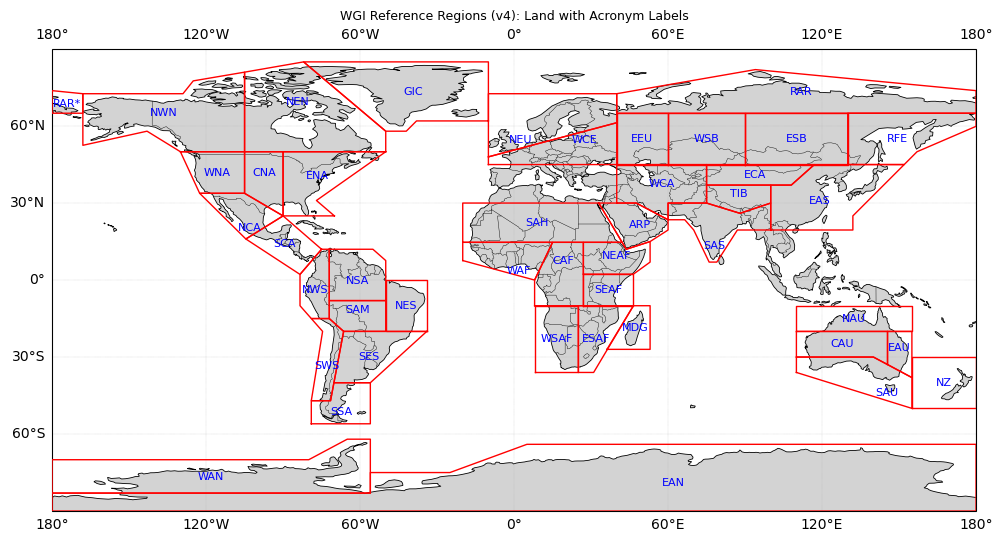

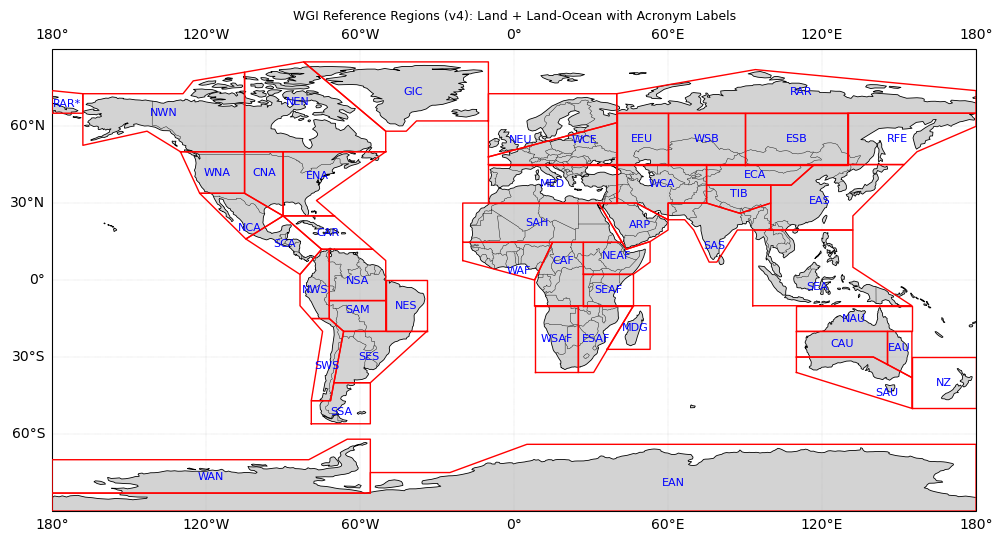

In [6]:
# %% Plot figures with smaller title font
# Configure the desired title fontsize once here
TITLE_FONTSIZE = 9  # try 8–10 for slide-friendly titles

if PLOT_LAND:
    # Build geometries for Land-only regions
    regions_land = build_region_geoms(df, surfaces=['Land'])

    # Create figure/axes and draw the map
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    plot_regions(ax, regions_land, title='WGI Reference Regions (v4): Land with Acronym Labels')

    # Make the title smaller (override what plot_regions set)
    ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE)

    # Export
    for ext in SAVE_FORMATS:
        fig.savefig(f'{FN_LAND}.{ext}')
    plt.show()

if PLOT_LAND_PLUS_LANDOCEAN:
    # Build geometries for Land + Land–Ocean (hybrid) regions; excludes ocean-only regions
    regions_landocean = build_region_geoms(df, surfaces=['Land', 'Land-Ocean'])

    # Create figure/axes and draw the map
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    plot_regions(ax, regions_landocean, title='WGI Reference Regions (v4): Land + Land-Ocean with Acronym Labels')

    # Make the title smaller (override what plot_regions set)
    ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE)

    # Export
    for ext in SAVE_FORMATS:
        fig.savefig(f'{FN_LAND_PLUS_LANDOCEAN}.{ext}')
    plt.show()
    
    root_save = 'Replication_Building_Emulators/figures_replication/figure_10/figs_replication/'
    fig.savefig(root_save + 'figure_10.png')


## 6) Why are there *two* figures?

- In the paper, Figure 10, we display the **“Land + Land‑Ocean”** regions. That is our **Figure 2** in this notebook.
- In addition, many workflows also want the **Land-only** panel (without the three hybrid regions). That is our **Figure 1**.

If you only need the *Land + Land‑Ocean* panel to mirror the screenshot, simply set:
```python
PLOT_LAND = False
PLOT_LAND_PLUS_LANDOCEAN = True
```
and re-run Section 5 of this notebook.

## 7) References

- Iturbide, M., Gutiérrez, J. M., Bedia, J., Cimadevilla, E., Díez-Sierra, J., Manzanas, R., et al. (2020).
  *An update of IPCC climate reference regions for subcontinental analysis of climate model data: definition and aggregated datasets.*
  **Earth System Science Data**, 12, 2959–2970. https://doi.org/10.5194/essd-12-2959-2020

- The coordinate CSV enumerates region vertices for the AR6 WGI v4 reference regions.